# Bach network

This work is a based on my previous work in this repo: https://github.com/araobp/learning-nlp

Date: 2024/01/05 - 2024/01/06, 2024/03/18

Reference: https://youtu.be/fAHkJ_Dhr50

Free book "Johann Sebastian Bach: His Life, Art, and Work" from Project Gutenberg: https://www.gutenberg.org/ebooks/35041

In [1]:
import spacy
from spacy import displacy
import re
nlp = spacy.load('en_core_web_trf')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [2]:
import yaml

with open('../data/pg35041-paragraphs.yaml', 'r', encoding='utf-8') as f:
    paragraphs = yaml.safe_load(f.read())    

## Import data

In [3]:
with open('../data/names.yaml', 'r') as f:
    imported = yaml.safe_load(f.read())
    NAMES = imported['named_entity']
    NAMES_REPLACE = imported['replace']

with open('../data/german_cities.yaml', 'r') as f:
    imported = yaml.safe_load(f.read())
    GERMAN_CITIES = imported['named_entity']
    GERMAN_CITIES_REPLACE = imported['replace']

with open('../data/orgs.yaml', 'r') as f:
    imported = yaml.safe_load(f.read())
    ORGS = imported['named_entity']
    ORGS_REPLACE = imported['replace']

## Enumeration Search Function

In [4]:
def _align_name(name):
    name = name.replace("'s", "")
    return NAMES_REPLACE[name] if name in NAMES_REPLACE else name

def _align_names(namelist):
    namelist_ = [name.replace("'s", "") for name in namelist]
    return [NAMES_REPLACE[name] if name in NAMES_REPLACE else name for name in namelist_]

# Test
print(_align_name('Bach'))
print(_align_names(['Bach', 'Carl Philipp']))

Johann Sebastian Bach
['Johann Sebastian Bach', 'Carl Philipp Emanuel Bach']


In [5]:
# Search for the first token in the group
def _findHead(token, head):
    if token.dep_ == 'conj':
        _findHead(token.head, head)
    else:
        head.append(token)

# Search for tokens enumerated as PROPN
def _findGroup(token, groups):
    for t in token.children:
        if (t.pos_ == 'PROPN' and t.dep_ == 'conj'):
            #print(t.head.text, t.text)
            head = []
            _findHead(t, head)
            #print(head)
            head_ = head[0]
            if not head_ in groups:
                groups[head_] = [head_]
            groups[head_].append(t)
        try:
            first = next(t.children)
            _findGroup(t, groups)
        except StopIteration:
            pass

# To obtain the full name, connect all PROPN entities bound by compound relationships
def _fullname(token, text=False):
    name = []
    for t in token.children:
        if t.dep_ == 'compound':
            name.append(t)
    name.append(token)
    if text:
        return ' '.join([token.text for token in name])
    else:
        return name

# In a sentence, search for an enumeration of names, and return an array of enumeration groups 
# and an array of names that are not included in any enumeration group.
def findPersonsInGroup(doc):
    groups = []

    ents = [ent for ent in doc.ents if ent.label_ == 'PERSON' and ent.text in NAMES]
    
    persons_ = [ent.text for ent in ents if ent.label_ == 'PERSON']
    spans = [[ent.start_char, ent.end_char, _align_name(ent.text)] for ent in ents]
    
    persons_ = _align_names(persons_)
    persons = set(persons_)
    for token in doc:
        if token.dep_ == 'ROOT':
            root = token
            groups_ = {}
            _findGroup(root, groups_)
            for group in groups_.values():
                fullname_list = [_fullname(token, text=True) for token in group]
                fullname_list = _align_names(fullname_list)
                persons_fullname_list = [name for name in fullname_list if name in persons]
                if len(persons_fullname_list) > 0:
                    groups.append(set(persons_fullname_list))

    return (groups, persons, spans)

## German cities and organizations

In [6]:
def findGermanCities(doc):
    ents = [ent for ent in doc.ents if ent.label_ == 'GPE' and ent.text in GERMAN_CITIES]
    spans = [[ent.start_char, ent.end_char] for ent in ents]
    german_cities = [ent.text for ent in ents]
    return ([GERMAN_CITIES_REPLACE[city] if city in GERMAN_CITIES_REPLACE else city for city in german_cities], span)

def findOrgs(doc):
    ents = [ent for ent in doc.ents if ent.label_ == 'ORG' and ent.text in GERMAN_CITIES]
    spans = [[ent.start_char, ent.end_char] for ent in ents]
    german_cities = [ent.text for ent in ents]
    return ([GERMAN_CITIES_REPLACE[city] if city in GERMAN_CITIES_REPLACE else city for city in german_cities], span)

## Generating weighted node-edge-node pairs on a paragraph basis.

In [7]:
import itertools

def isPairInGroup(node_a, node_b, groups):
    is_group_member = False
    for group in groups:
        if node_a in group and node_b in group:
            is_group_member = True
            break
    if is_group_member:
        weight = 2/len(group)  # The weights between members within the group exhibit an inverse proportional relationship.
    else:
        weight = 1  # The weight is always set to 1 outside the group.
    return (is_group_member, weight)

network = []
spans_in_paragraph = {}
p_idx = 0
for doc in nlp.pipe(paragraphs):
    groups, persons, spans = findPersonsInGroup(doc)
    spans_in_paragraph[p_idx] = spans
    for node_pair in itertools.combinations(persons, r=2):
        weight = isPairInGroup(node_pair[0], node_pair[1], groups)
        network.append([p_idx, node_pair[0], node_pair[1], weight[1]])
    p_idx += 1

In [8]:
import pandas as pd
df = pd.DataFrame(network, columns=['p_idx', 'source', 'target', 'weight']).round(2)
df.sample(10)

,p_idx,source,target,weight
299,123,Georg Philipp Telemann,Zelenka,0.25
333,123,Wilhelm Friedemann Bach,Handel,1.00
0,7,Johann Ambrosius Bach,Johann Sebastian Bach,1.00
212,76,Frescobaldi,Johann Sebastian Bach,1.00
108,49,August Friedrich Müller,Maria Amalia,1.00
273,115,Johann Sebastian Bach,Wilhelm Friedemann Bach,1.00
260,110,Fux,Berardi,0.67
18,8,Bruhns,Johann Sebastian Bach,1.00
247,82,Johann Sebastian Bach,Hoffmeister,1.00
55,15,Leopold,Reinken,1.00


## Output paragraph

In [9]:
[[key, spans_in_paragraph[key]] for key in list(spans_in_paragraph.keys())[:3]]

[[0, [[99, 103, 'Johann Sebastian Bach']]],
 [1, [[0, 9, 'Veit Bach']]],
 [2, [[193, 204, 'Veit Bach']]]]

In [10]:
with open('../docs/paragraphs.js', 'w', encoding='utf-8') as f:
    f.write(f'var paragraphs = {paragraphs};\n\nvar spans = {spans_in_paragraph};')

## Sort source and target alphabetically for each node-edge-node pair.

In [11]:
def swap(row):
    if row.source > row.target:  # target is lphabetically before source
        source = row.source
        row.source = row.target
        row.target = source
    return row

df = df.apply(swap, axis=1)
df.sample(10)

,p_idx,source,target,weight
28,8,Johann Sebastian Bach,Pachelbel,1.00
40,13,Johann Sebastian Bach,Kirchhoff,1.00
126,50,Altnikol,Christian Weiss,1.00
207,76,Böhm,Kerl,0.20
307,123,Johann Sebastian Bach,Zelenka,1.00
134,50,Johann Abraham Birnbaum,Marianne von Ziegler,1.00
253,95,Handel,Johann Sebastian Bach,1.00
303,123,Benda,Georg Philipp Telemann,0.25
62,17,Frederick the Great,Wilhelm Friedemann Bach,1.00
269,112,Carl Philipp Emanuel Bach,Johann Sebastian Bach,1.00


## Grouping by source and target

In [12]:
relationships_df = df.reset_index().groupby(['source', 'target'])[['p_idx', 'weight']].agg(list)
relationships_df['weight'] = relationships_df['weight'].apply(sum)
relationships_df = relationships_df.reset_index()
relationships_df.sample(10)

,source,target,p_idx,weight
283,Pachelbel,Strungk,[76],0.20
40,Benda,Johann Sebastian Bach,[123],1.00
110,Couperin,Volumier,[14],1.00
18,August Friedrich Müller,Gottlieb Kortte,[48],1.00
156,Fritz Volbach,Kittel,[52],1.00
204,Handel,Zelenka,[123],0.25
31,Beethoven,Philipp Emmanuel,[53],1.00
249,Johann Sebastian Bach,Kühnel,[82],1.00
223,Johann August Ernesti,Johann Sebastian Bach,[48],1.00
280,Maria Amalia,Wilhelm Friedemann Bach,[143],1.00


## Drawing a relational diagram with NetworkX

In [13]:
import networkx as nx
G = nx.from_pandas_edgelist(relationships_df,
                            source = 'source',
                            target = 'target',
                            edge_attr = ['weight', 'p_idx'],
                            create_using=nx.Graph())

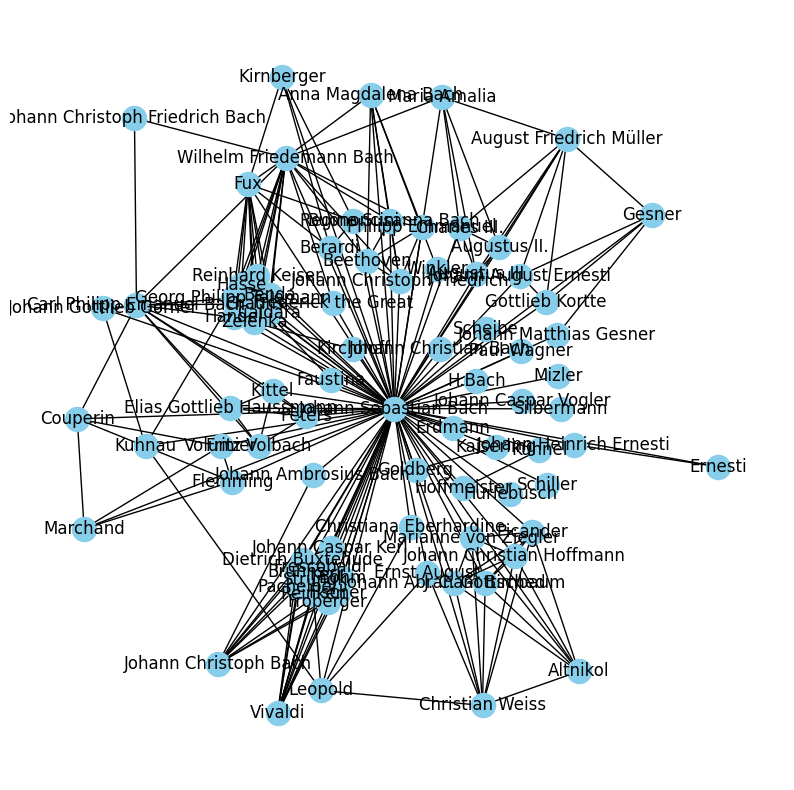

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, ax=ax, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

## Drawing a graph with pyvis

In [15]:
from pyvis.network import Network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white', cdn_resources='in_line')

node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G, edge_scaling=True, show_edge_weights=True)
net.show('bach.html')

bach.html


## Centrality

<Axes: >

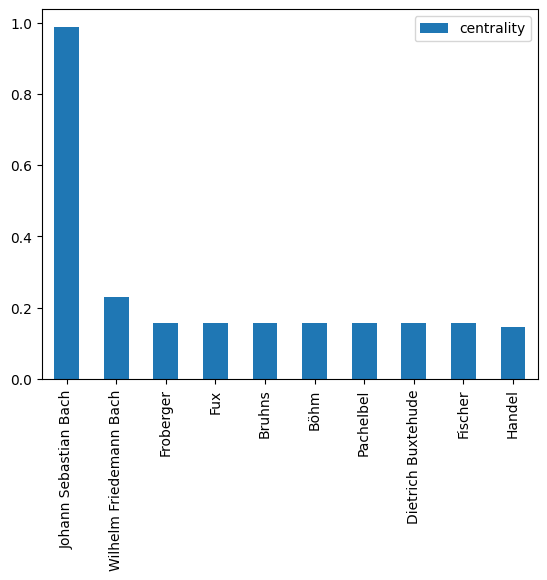

In [16]:
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

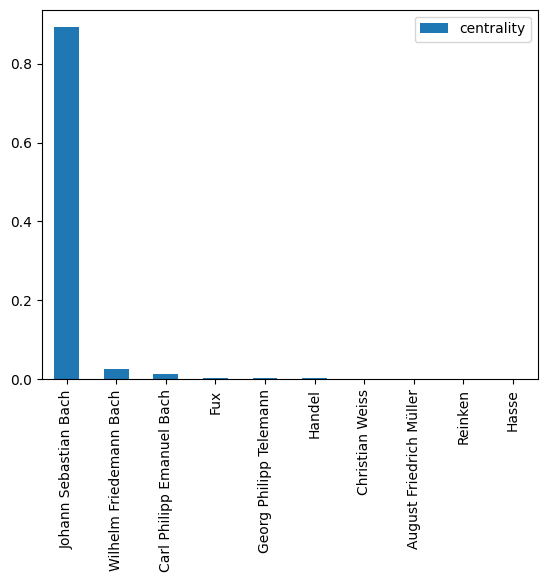

In [17]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

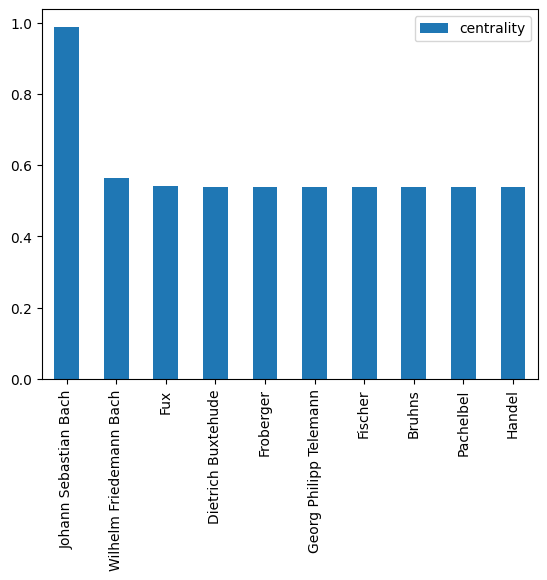

In [18]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

## Detecting communities

In [19]:
from community import community_louvain

communities = community_louvain.best_partition(G)
MAX_COMMUNITY_IDX = max(communities.values())

nx.set_node_attributes(G, communities, 'group')

com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')
com_net.from_nx(G)
com_net.show_buttons(filter_=['physics'])
com_net.show("bach_communities.html")

bach_communities.html


## HTML color list generation function for communities

In [20]:
import matplotlib.pyplot as plt
import random

def html_colors(max_group_index, cmap='rainbow'):

    def rgb2hex(cmap_color):
        r = int(cmap_color[0]*255)
        g = int(cmap_color[1]*255)
        b = int(cmap_color[2]*255)
        return "#{:02x}{:02x}{:02x}".format(r,g,b)
    
    cmap_idx = [i / max_group_index for i in range(0, max_group_index + 1 )]
    random.shuffle(cmap_idx)
    return [rgb2hex(plt.get_cmap(cmap)(i)) for i in cmap_idx]

In [21]:
colors = html_colors(MAX_COMMUNITY_IDX, 'Pastel1')

## Outputting data for graphology.js

In [22]:
nodes = []
for node in G.nodes.data(data=True):
    value = node[1]['size']
    group = node[1]['group']
    color = colors[group]
    nodes.append({'key': node[0], 'attributes': {'value': value, 'group': group, 'color': color}})
nodes

[{'key': 'Altnikol',
  'attributes': {'value': 7, 'group': 3, 'color': '#b3cde3'}},
 {'key': 'Christian Weiss',
  'attributes': {'value': 9, 'group': 3, 'color': '#b3cde3'}},
 {'key': 'J. C. Gottsched',
  'attributes': {'value': 7, 'group': 3, 'color': '#b3cde3'}},
 {'key': 'Johann Abraham Birnbaum',
  'attributes': {'value': 7, 'group': 3, 'color': '#b3cde3'}},
 {'key': 'Johann Christian Hoffmann',
  'attributes': {'value': 7, 'group': 3, 'color': '#b3cde3'}},
 {'key': 'Johann Sebastian Bach',
  'attributes': {'value': 82, 'group': 1, 'color': '#fed9a6'}},
 {'key': 'Marianne von Ziegler',
  'attributes': {'value': 7, 'group': 3, 'color': '#b3cde3'}},
 {'key': 'Picander',
  'attributes': {'value': 7, 'group': 3, 'color': '#b3cde3'}},
 {'key': 'Anna Magdalena Bach',
  'attributes': {'value': 7, 'group': 2, 'color': '#decbe4'}},
 {'key': 'Beethoven',
  'attributes': {'value': 6, 'group': 2, 'color': '#decbe4'}},
 {'key': 'Johann Christoph Friedrich',
  'attributes': {'value': 6, 'group':

In [23]:
edges = []
for edge in G.edges.data(data=True):
    source = edge[0]
    target = edge[1]
    value = edge[2]['value']
    p_idxs = edge[2]['p_idx']
    edges.append({'key': f'{source}:{target}','source': source, 'target': target, 'attributes': {'value': value, 'pIdx': p_idxs}})
edges[:10]

[{'key': 'Altnikol:Christian Weiss',
  'source': 'Altnikol',
  'target': 'Christian Weiss',
  'attributes': {'value': 1.0, 'pIdx': [50]}},
 {'key': 'Altnikol:J. C. Gottsched',
  'source': 'Altnikol',
  'target': 'J. C. Gottsched',
  'attributes': {'value': 1.0, 'pIdx': [50]}},
 {'key': 'Altnikol:Johann Abraham Birnbaum',
  'source': 'Altnikol',
  'target': 'Johann Abraham Birnbaum',
  'attributes': {'value': 1.0, 'pIdx': [50]}},
 {'key': 'Altnikol:Johann Christian Hoffmann',
  'source': 'Altnikol',
  'target': 'Johann Christian Hoffmann',
  'attributes': {'value': 1.0, 'pIdx': [50]}},
 {'key': 'Altnikol:Johann Sebastian Bach',
  'source': 'Altnikol',
  'target': 'Johann Sebastian Bach',
  'attributes': {'value': 2.0, 'pIdx': [50, 133]}},
 {'key': 'Altnikol:Marianne von Ziegler',
  'source': 'Altnikol',
  'target': 'Marianne von Ziegler',
  'attributes': {'value': 1.0, 'pIdx': [50]}},
 {'key': 'Altnikol:Picander',
  'source': 'Altnikol',
  'target': 'Picander',
  'attributes': {'value':

In [24]:
with open('../docs/graph_data.js', 'w', encoding='utf-8') as f:
    f.write(f'var nodes = {nodes};\n\nvar edges = {edges};')